In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def show_tensor_images(image_tensor, num_images=25, size=(3, 256, 256)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    inv_normalize = transforms.Normalize(
      mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
      std=[1/0.229, 1/0.224, 1/0.225]
    )
    image_tensor = inv_normalize(image_tensor)
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### Download the facades dataset
#####(https://cmp.felk.cvut.cz/~tylecr1/facade/)

In [3]:
# https://github.com/pytorch/vision/blob/main/torchvision/datasets/utils.py

# Unzips the facades dataset into the main directory in Colab
from torchvision.datasets.utils import download_and_extract_archive
url = 'https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip'
root = '/content'
download_and_extract_archive(url, root)

  0%|          | 0/36517004 [00:00<?, ?it/s]

Extracting /content/CMP_facade_DB_base.zip to /content


###Model
#####Code used in paper:
https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/voc-fcn8s/net.py

#####Pytorch implementation of various FCN models
https://github.com/wkentaro/pytorch-fcn/blob/45c6b2d3f553cbe6369822d17a7a51dfe9328662/torchfcn/models/fcn8s.py#L17

In [4]:
def conv_relu(nin, nout, ks=3, stride=1, pad=1):
    '''
    Creates a Conv2d and ReLU layer.
    '''
    conv = nn.Conv2d(nin, nout, ks, stride, pad)
    return conv, nn.ReLU(inplace=True)

In [5]:
def max_pool(ks=2, stride=2):
    '''
    Creates a max pooling layer.
    '''
    return nn.MaxPool2d(ks, stride, ceil_mode=True)

In [6]:
def crop(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels.
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    middle_height = image.shape[2] // 2
    middle_width = image.shape[3] // 2
    starting_height = middle_height - round(new_shape[2] / 2)
    final_height = starting_height + new_shape[2]
    starting_width = middle_width - round(new_shape[3] / 2)
    final_width = starting_width + new_shape[3]
    cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]
    return cropped_image

In [7]:
class FCN_8s(nn.Module):
    '''
    FCN-8s Class
    Values: n_class: the number of classes
    '''
    def __init__(self, n_class=12):
        super(FCN_8s, self).__init__()
        self.conv1_1, self.relu1_1 = conv_relu(3, 64, pad=100)
        self.conv1_2, self.relu1_2 = conv_relu(64, 64)
        self.pool1 = max_pool()

        self.conv2_1, self.relu2_1 = conv_relu(64, 128)
        self.conv2_2, self.relu2_2 = conv_relu(128, 128)
        self.pool2 = max_pool()

        self.conv3_1, self.relu3_1 = conv_relu(128, 256)
        self.conv3_2, self.relu3_2 = conv_relu(256, 256)
        self.conv3_3, self.relu3_3 = conv_relu(256, 256)
        self.pool3 = max_pool()

        self.conv4_1, self.relu4_1 = conv_relu(256, 512)
        self.conv4_2, self.relu4_2 = conv_relu(512, 512)
        self.conv4_3, self.relu4_3 = conv_relu(512, 512)
        self.pool4 = max_pool()

        self.conv5_1, self.relu5_1 = conv_relu(512, 512)
        self.conv5_2, self.relu5_2 = conv_relu(512, 512)
        self.conv5_3, self.relu5_3 = conv_relu(512, 512)
        self.pool5 = max_pool()

        self.fc6, self.relu6 = conv_relu(512, 4096, ks=7, pad=0)
        self.drop6 = nn.Dropout2d()
        self.fc7, self.relu7 = conv_relu(4096, 4096, ks=1, pad=0)
        self.drop7 = nn.Dropout2d()
        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.upscore2 = nn.ConvTranspose2d(n_class, n_class, 4, 2, bias=False)

        self.score_pool4 = nn.Conv2d(512, n_class, 1)
        # crop score_pool4 to upscore2
        # add score_pool4 and upscore2
        self.upscore_pool4 = nn.ConvTranspose2d(n_class, n_class, 4, 2, bias=False)

        self.score_pool3 = nn.Conv2d(256, n_class, 1)
        # crop score_pool3 to upscore_pool4
        # add score_pool3 to upscore_pool4
        self.upscore8 = nn.ConvTranspose2d(n_class, n_class, 16, 8, bias=False)
        # crop self.upscore8 to data

    def forward(self, x):
        x1_1 = self.relu1_1(self.conv1_1(x))
        x1_2 = self.relu1_2(self.conv1_2(x1_1))
        x1_3 = self.pool1(x1_2)

        x2_1 = self.relu2_1(self.conv2_1(x1_3))
        x2_2 = self.relu2_2(self.conv2_2(x2_1))
        x2_3 = self.pool2(x2_2)

        x3_1 = self.relu3_1(self.conv3_1(x2_3))
        x3_2 = self.relu3_2(self.conv3_2(x3_1))
        x3_3 = self.relu3_3(self.conv3_3(x3_2))
        x3_4 = self.pool3(x3_3)

        x4_1 = self.relu4_1(self.conv4_1(x3_4))
        x4_2 = self.relu4_2(self.conv4_2(x4_1))
        x4_3 = self.relu4_3(self.conv4_3(x4_2))
        x4_4 = self.pool4(x4_3)

        x5_1 = self.relu5_1(self.conv5_1(x4_4))
        x5_2 = self.relu5_2(self.conv5_2(x5_1))
        x5_3 = self.relu5_3(self.conv5_3(x5_2))
        x5_4 = self.pool5(x5_3)

        x6_1 = self.relu6(self.fc6(x5_4))
        x6_2 = self.drop6(x6_1)

        x7_1 = self.relu7(self.fc7(x6_2))
        x7_2 = self.drop7(x7_1)
        
        x8_1 = self.score_fr(x7_2)
        x8_2 = self.upscore2(x8_1)

        x9_1 = self.score_pool4(x4_4)
        x9_2 = crop(x9_1, x8_2.size())
        x9_3 = x8_2 + x9_2
        x9_4 = self.upscore_pool4(x9_3)

        x10_1 = self.score_pool3(x3_4)
        x10_2 = crop(x10_1, x9_4.size())
        x10_3 = x10_2 + x9_4
        x10_4 = self.upscore8(x10_3)

        return crop(x10_4, x.size())

In [8]:
n_epochs = 20
input_dim = 3
real_dim = 3
display_step = 500
batch_size = 6
lr = 0.0002
target_shape = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Colors that the annotated images use
colors = (
    0.003921568859368563,
    0.007843137718737125,
    0.0117647061124444,
    0.01568627543747425,
    0.019607843831181526,
    0.0235294122248888,
    0.027450980618596077,
    0.0313725508749485,
    0.03529411926865578,
    0.03921568766236305,
    0.04313725605607033,
    0.0470588244497776
)

In [9]:
from torchsummary import summary
summary(FCN_8s().to(device), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 454, 454]           1,792
              ReLU-2         [-1, 64, 454, 454]               0
            Conv2d-3         [-1, 64, 454, 454]          36,928
              ReLU-4         [-1, 64, 454, 454]               0
         MaxPool2d-5         [-1, 64, 227, 227]               0
            Conv2d-6        [-1, 128, 227, 227]          73,856
              ReLU-7        [-1, 128, 227, 227]               0
            Conv2d-8        [-1, 128, 227, 227]         147,584
              ReLU-9        [-1, 128, 227, 227]               0
        MaxPool2d-10        [-1, 128, 114, 114]               0
           Conv2d-11        [-1, 256, 114, 114]         295,168
             ReLU-12        [-1, 256, 114, 114]               0
           Conv2d-13        [-1, 256, 114, 114]         590,080
             ReLU-14        [-1, 256, 1

###Create Dataset

In [10]:
def img_tensor(i):
    '''
    Converts a 3 channel tensor into a 12 channel 
    tensor, where each channel representa a separate class.
    '''
    img = torch.zeros((12, i.shape[0], i.shape[1]))
    for row in range(i.shape[0]):
        for col in range(i.shape[1]):
            img[colors.index(i[row, col]), row, col] = 1
    return img

In [11]:
import matplotlib

def vis_tensor(image_tensor):
    '''
    Function for visualizing annotated images.
    Values:
    image_tensor: The 12 channel image tensor to be visualized.
    '''
    img = torch.empty((image_tensor.shape[1], image_tensor.shape[2]))
    max_img = torch.argmax(image_tensor, dim=0)
    for row in range(image_tensor.shape[1]):
        for col in range(image_tensor.shape[2]):
            img[row][col] = colors[max_img[row][col]]
    jet = matplotlib.cm.jet
    plt.imshow(img, cmap=jet, interpolation='nearest')
    plt.show()

In [12]:
from PIL import Image
from torch.utils.data import Dataset
class PairedDataset(Dataset):
    '''
    Creates a dataset where each entry contains 2 tensors, the 
    first being the input, and the second being the ground truth.
    Values:
    im_1_paths: A list containing the paths of the input images
    im_2_list: A list containing the annotated tensors
    '''
    def __init__(self, im_1_paths, im_2_paths, transform):
        self.im_1_paths = im_1_paths
        self.im_2_paths = im_2_paths
        self.transform = transform
        
    def __getitem__(self, index):
        x = Image.open(self.im_1_paths[index])
        x = x.resize((target_shape, target_shape))
        if self.transform:
            x = self.transform(x)
        return x, self.im_2_paths[index]

    def __len__(self):
        return len(self.im_1_paths)

In [13]:
import os
file_list_img = []
file_list_seg = []
for file in os.listdir("/content/base"):
    if file[-4:] == ".png":
      file_list_seg.append(f"/content/base/{file}")
    elif file[-4:] == ".jpg":
      file_list_img.append(f"/content/base/{file}")

file_list_img.sort()
file_list_seg.sort()

# Make sure that all images are paired
for img, seg in zip(file_list_img, file_list_seg):
  assert img[:-4] == seg[:-4]

print(file_list_seg)
print(file_list_img)

['/content/base/cmp_b0001.png', '/content/base/cmp_b0002.png', '/content/base/cmp_b0003.png', '/content/base/cmp_b0004.png', '/content/base/cmp_b0005.png', '/content/base/cmp_b0006.png', '/content/base/cmp_b0007.png', '/content/base/cmp_b0008.png', '/content/base/cmp_b0009.png', '/content/base/cmp_b0010.png', '/content/base/cmp_b0011.png', '/content/base/cmp_b0012.png', '/content/base/cmp_b0013.png', '/content/base/cmp_b0014.png', '/content/base/cmp_b0015.png', '/content/base/cmp_b0016.png', '/content/base/cmp_b0017.png', '/content/base/cmp_b0018.png', '/content/base/cmp_b0019.png', '/content/base/cmp_b0020.png', '/content/base/cmp_b0021.png', '/content/base/cmp_b0022.png', '/content/base/cmp_b0023.png', '/content/base/cmp_b0024.png', '/content/base/cmp_b0025.png', '/content/base/cmp_b0026.png', '/content/base/cmp_b0027.png', '/content/base/cmp_b0028.png', '/content/base/cmp_b0029.png', '/content/base/cmp_b0030.png', '/content/base/cmp_b0031.png', '/content/base/cmp_b0032.png', '/conte

In [14]:
# ### Run if you do not have seg.pt ###

# from torchvision import transforms
# seg_list = []
# progress = 0
# for i in file_list_seg:
#   y = Image.open(i)
#   y = y.resize((target_shape, target_shape))
#   y = transforms.ToTensor()(y).squeeze()
#   y = img_tensor(y)
#   seg_list.append(y)
#   progress += 1
#   print(f"Progress: {progress} / {len(file_list_seg)}")
  
# torch.save(seg_list, "seg.pt")

In [15]:
seg_list = torch.load("/content/drive/MyDrive/seg.pt")

In [16]:
from torchvision import transforms

# Using same specifications as https://pytorch.org/vision/stable/models.html#semantic-segmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [17]:
# Split data into train and test datasets
split = len(file_list_img) * 9 // 10
train_data = PairedDataset(file_list_img[:split], seg_list[:split], transform)
test_data = PairedDataset(file_list_img[split+1:], seg_list[split+1:], transform)

###Intitialize Model

In [18]:
from numpy.core.numeric import False_
model = FCN_8s().to(device)
model_opt = torch.optim.Adam(model.parameters(), lr=lr)

def weights_init(m):
    '''
    Initializes the model weights.
    '''
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)

pretrained = True
if pretrained:
    loaded_state = torch.load("/content/drive/MyDrive/fcn8s_1000.pt")
    model.load_state_dict(loaded_state["model"])
    model_opt.load_state_dict(loaded_state["model_opt"])
else:
    model = model.apply(weights_init)

In [19]:
def get_loss(img, seg):
    '''
    Return the cross entropy between the generated image and the ground truth.
    '''
    loss = nn.CrossEntropyLoss()
    return loss(img, seg)

###Train Model

  0%|          | 0/57 [00:00<?, ?it/s]

Pretrained initial state


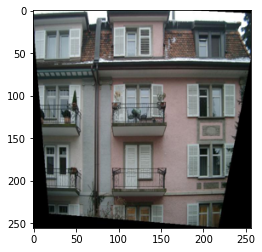

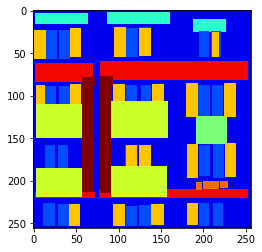

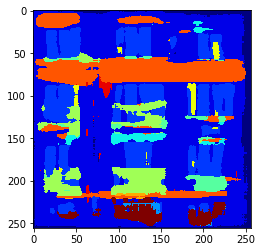

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 8: Step 500: Loss: 0.0779336805716157


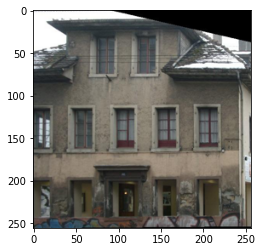

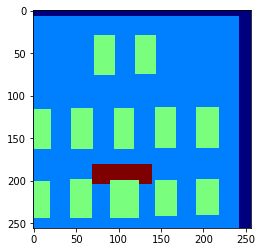

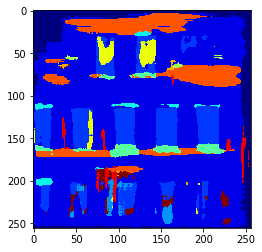

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 17: Step 1000: Loss: 0.0756094189658761


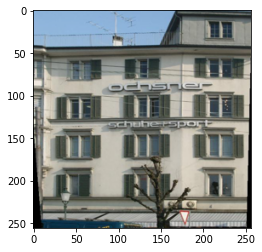

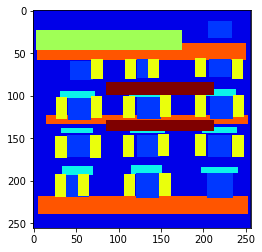

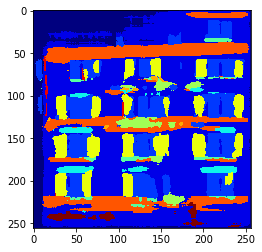

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

In [20]:
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

def train(save_model=True):
    '''
    Train the model.
    '''
    mean_loss = 0
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    cur_step = 0

    test_imgs = torch.randperm(len(test_data))
    test_idx = 0

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for img, seg in tqdm(dataloader):
            cur_batch_size = len(img)
            img = img.to(device)
            seg = seg.to(device)

            # Update Model
            model_opt.zero_grad()
            model_pred = model(img)
            model_loss = get_loss(model_pred, seg)
            model_loss.backward(retain_graph=True)
            model_opt.step()

            # Keep track of the average loss
            mean_loss += model_loss.item() / display_step

            # Visualization code
            if cur_step % display_step == 0:
                if cur_step > 0:
                    print(f"Epoch {epoch}: Step {cur_step}: Loss: {mean_loss}")
                else:
                    print("Pretrained initial state")
                # Predict from test data
                test_pred = model(torch.unsqueeze(test_data[test_imgs[test_idx]][0].to(device), 0))
                show_tensor_images(test_data[test_imgs[test_idx]][0])
                vis_tensor(test_data[test_imgs[test_idx]][1])
                vis_tensor(test_pred.squeeze())
                

                test_idx = (test_idx + 1) % len(test_imgs)
                mean_loss = 0
                # Change save_model to True to save the model
                if save_model:
                    torch.save({'model': model.state_dict(),
                        'model_opt': model_opt.state_dict()
                    }, f"fcn8s_{cur_step}.pt")
            cur_step += 1
train()

### Evaluate Model

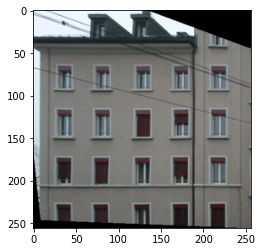

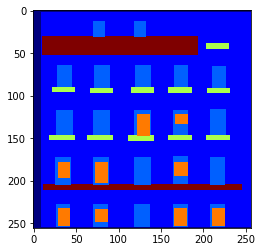

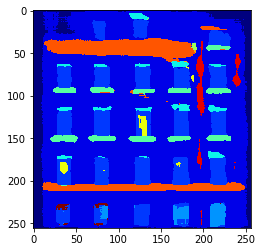

In [68]:
test_imgs = torch.randperm(len(test_data))
test_idx = 1

test_pred = model(torch.unsqueeze(test_data[test_imgs[test_idx]][0].to(device), 0))
show_tensor_images(test_data[test_imgs[test_idx]][0])
test_seg = test_data[test_imgs[test_idx]][1].to(device)
test_img = test_pred.squeeze()
vis_tensor(test_seg)
vis_tensor(test_img)

In [46]:
def mIOU(img, seg):
    '''
    Calculate the mean intersection over union between two 
    twelve-channeled tensors.
    IOU = (true positive) 
        / (true positive + false positive + false negative)
    '''
    SMOOTH = 1e-6
    img = torch.argmax(img, dim=0)
    seg = torch.argmax(seg, dim=0)
    ious = []

    for channel in range(12):
        true_img = img == channel
        true_seg = seg == channel
        intersection = torch.logical_and(true_img, true_seg).sum()
        union = torch.logical_or(true_img, true_seg).sum()
        ious.append((intersection + SMOOTH) / (union + SMOOTH))   # Avoid 0/0
    
    return float(torch.mean(torch.tensor(ious)))


In [69]:
mIOU(test_img, test_seg)

0.28287601470947266

In [29]:
def per_pixel_acc(img, seg):
    '''
    Calculate the mean per-pixel accuracy between two tensors.
    Accuracy = (true positive + true negative) 
             / (true positive + true negative + false positive + false negative)
    '''
    img = torch.argmax(img, dim=0).view(-1)
    seg = torch.argmax(seg, dim=0).view(-1)

    img_eq_seg = img == seg

    return float(img_eq_seg.sum() / (target_shape * target_shape))


In [70]:
per_pixel_acc(test_img, test_seg)

0.8154449462890625